The bank has capacity to contact only 15% of the clients with a marketing offer and each client can be contacted only once at most. Using statistical analysis, predictive modelling and common sense determine:

* Which clients have higher propensity to buy consumer loan?

### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
warnings.filterwarnings('ignore') 
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (4, 3)

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier


from scipy.stats import skew
from sklearn.preprocessing import Normalizer

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#load the file
Soc_dem = pd.read_excel(r"C:\Users\piush\Desktop\Dataset\KBC\KBC_Marketing.xlsx", sheetname=1)
Products_ActBalance  = pd.read_excel(r"C:\Users\piush\Desktop\Dataset\KBC\KBC_Marketing.xlsx", sheetname=2)
Inflow_Outflow = pd.read_excel(r"C:\Users\piush\Desktop\Dataset\KBC\KBC_Marketing.xlsx", sheetname=3)
Sales_Revenues  = pd.read_excel(r"C:\Users\piush\Desktop\Dataset\KBC\KBC_Marketing.xlsx", sheetname=4)


In [3]:
print ("Information for Soc_dem")
print ("------------------")
print ("Shape of dataset set:", Soc_dem.shape, "\n")
print ("Column Headers:", list(Soc_dem.columns.values), "\n")
print (Soc_dem.dtypes)
print("=" * 60)

missing_values = []
for column in Soc_dem:
    # Find all the unique feature values
    uniq = Soc_dem[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("Listing up to 10 unique values")
    print (uniq[0:10])
    print ("=" * 60)
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(Soc_dem[column]).sum())
        missing_values.append(s)
print ("*" * 60)
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print("=" * 60)
#get summary of numerical variables
print("Summary")
print(Soc_dem.describe())

Information for Soc_dem
------------------
Shape of dataset set: (1615, 4) 

Column Headers: ['Client', 'Sex', 'Age', 'Tenure'] 

Client     int64
Sex       object
Age        int64
Tenure     int64
dtype: object
'Client' has 1615 unique values
Listing up to 10 unique values
[ 909 1217  850 1473 1038  225  699  827 1231  528]
'Sex' has 3 unique values
['M' 'F' nan]
'Age' has 94 unique values
Listing up to 10 unique values
[21 38 49 54 29 14 37 57  6 19]
'Tenure' has 248 unique values
Listing up to 10 unique values
[ 27 165  44  34 106 187 175  50 232  70]
************************************************************
Features with missing values:
['Sex has 3 missing']


Summary
            Client          Age       Tenure
count  1615.000000  1615.000000  1615.000000
mean    808.000000    42.848916   101.339938
std     466.354658    18.550529    64.917297
min       1.000000     0.000000     0.000000
25%     404.500000    29.000000    44.000000
50%     808.000000    41.000000    97.000000
7

###### Analysis of Soc-dem
We have 1615 values with Sex as categorical variable, There are no duplicate client id. We can get an idea of a possible skew in the data by comparing the mean to the median, i.e. the 50% figure. It looks like there is no skweness. The need to explore further observing from above:
1. Sex has three missing values.
2. Age has a minimum of zero
3. maximum of 97 ??
4. Tenure has some values as 0
###### Further Exploration

In [4]:
Soc_dem[Soc_dem['Sex'].isnull()]

,Client,Sex,Age,Tenure
422,1363,NaN,38,8
1062,953,NaN,50,35
1494,843,NaN,36,151


###### We will fill these values using mode

In [5]:
Soc_dem.loc[:, "Sex"] = Soc_dem.loc[:, "Sex"].fillna(Soc_dem['Sex'].mode()[0])

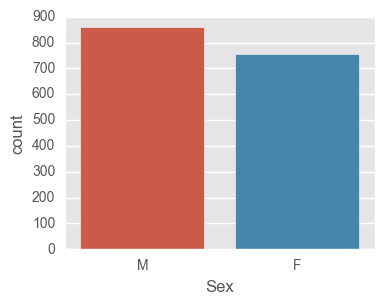

In [6]:
# Show value counts for a single categorical variable:
ax = sns.countplot(x="Sex", data=Soc_dem)

In [7]:
#Check when a value in a cloumn is zero
Soc_dem[(Soc_dem['Age'] == 0)].count()

Client    1
Sex       1
Age       1
Tenure    1
dtype: int64

In [8]:
#Check when a value in a cloumn is one
Soc_dem[(Soc_dem['Age'] == 1)].count()

Client    6
Sex       6
Age       6
Tenure    6
dtype: int64

In [9]:
#Check when a value in a cloumn is two
Soc_dem[(Soc_dem['Age'] == 2)].count()

Client    5
Sex       5
Age       5
Tenure    5
dtype: int64

In [10]:
#Check when a value in a cloumn is three
Soc_dem[(Soc_dem['Age'] == 3)].count()

Client    3
Sex       3
Age       3
Tenure    3
dtype: int64

###### It looks like parents are opening bank accounts when their children is born.

In [11]:
#Check when a value in a cloumn is 97
Soc_dem[(Soc_dem['Age'] == 97)]

,Client,Sex,Age,Tenure
299,25,F,97,181


###### There are other accounts with people at age above 90 so , we will leave it.

In [12]:
#Check when a value in a cloumn is zer0
Soc_dem[(Soc_dem['Tenure'] == 0)].count()

Client    19
Sex       19
Age       19
Tenure    19
dtype: int64

#### These accounts are newly opened.

In [13]:
print ("Information for Products_ActBalance")
print ("------------------")
print ("Shape of dataset set:", Products_ActBalance.shape, "\n")
print ("Column Headers:", list(Products_ActBalance.columns.values), "\n")
print (Products_ActBalance.dtypes)
print("=" * 60)

missing_values = []
for column in Products_ActBalance:
    # Find all the unique feature values
    uniq = Products_ActBalance[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("Listing up to 10 unique values")
    print (uniq[0:10])
    print ("=" * 60)
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(Products_ActBalance[column]).sum())
        missing_values.append(s)
print ("*" * 60)
print ("Features with missing values:\n{}\n\n" .format(missing_values))

print("=" * 60)
print("Summary")
print(Products_ActBalance.describe())

Information for Products_ActBalance
------------------
Shape of dataset set: (1615, 13) 

Column Headers: ['Client', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL'] 

Client          int64
Count_CA        int64
Count_SA      float64
Count_MF      float64
Count_OVD     float64
Count_CC      float64
Count_CL      float64
ActBal_CA     float64
ActBal_SA     float64
ActBal_MF     float64
ActBal_OVD    float64
ActBal_CC     float64
ActBal_CL     float64
dtype: object
'Client' has 1615 unique values
Listing up to 10 unique values
[ 909 1217  850 1473 1038  225  699  827 1231  528]
'Count_CA' has 4 unique values
[1 2 4 3]
'Count_SA' has 5 unique values
[ nan   1.   2.   3.   5.]
'Count_MF' has 30 unique values
Listing up to 10 unique values
[ nan   1.   2.   4.   3.  12.   5.   9.   6.  35.]
'Count_OVD' has 2 unique values
[  1.  nan]
'Count_CC' has 2 unique values
[ nan   1.]
'Count_CL' ha

###### Analysis of Products_ActBalance
There are 1615 disticnt values for clients. There are a lot of missing values. We can assume the nan is because of the clients not having ceratin type of bank account. We will fill all nan's value with zero.

The following are all categorical variables.
* Count_CA
* Count_SA
* Count_MF
* Count_OVD
* Count_CC
* Count_CL

There is skewness in the following accounts.
* ActBal_CA
* ActBal_SA
* ActBal_MF
* ActBal_OVD
* ActBal_CC
* ActBal_CL

##### Fill all the nan products wth zero as these products are not bought by the clients

In [14]:
#Products_ActBalance.fillna(0,inplace = True)

In [15]:
print ("Information for Inflow_Outflow")
print ("------------------")
print ("Shape of dataset set:", Inflow_Outflow.shape, "\n")
print ("Column Headers:", list(Inflow_Outflow.columns.values), "\n")
print (Inflow_Outflow.dtypes)
print("=" * 60)

missing_values = []
for column in Inflow_Outflow:
    # Find all the unique feature values
    uniq = Inflow_Outflow[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("Listing up to 10 unique values")
    print (uniq[0:10])
    print ("=" * 60)
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(Inflow_Outflow[column]).sum())
        missing_values.append(s)
print ("*" * 60)
print ("Features with missing values:\n{}\n\n" .format(missing_values))

print("=" * 60)
print("Summary")
print(Inflow_Outflow.describe())

Information for Inflow_Outflow
------------------
Shape of dataset set: (1587, 15) 

Column Headers: ['Client', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder'] 

Client                            int64
VolumeCred                      float64
VolumeCred_CA                   float64
TransactionsCred                  int64
TransactionsCred_CA               int64
VolumeDeb                       float64
VolumeDeb_CA                    float64
VolumeDebCash_Card              float64
VolumeDebCashless_Card          float64
VolumeDeb_PaymentOrder          float64
TransactionsDeb                   int64
TransactionsDeb_CA                int64
TransactionsDebCash_Card          int64
TransactionsDebCashless_Card      int64
TransactionsDeb_

###### Analysis of Inflow_Outlow
There are 1587 unique client values. We need to keep in mind if the missing values are from either the training or test set when compared to the sales_revenue. There are no missing values.

There is skewness in the following columns:
* VolumeCred
* VolumeCred_CA
* VolumeDeb
* VolumeDeb_CA
* VolumeDebCash_Card
* VolumeDebCashless_Card
* VolumeDeb_PaymentOrder

Other variables are categorical (ordinal).

###### We will normalize these columns after exploring the relationshipship with the target variables

In [16]:
print ("Information for Sales_Revenues")
print ("------------------")
print ("Shape of dataset set:", Sales_Revenues.shape, "\n")
print ("Column Headers:", list(Sales_Revenues.columns.values), "\n")
print (Sales_Revenues.dtypes)
print("=" * 60)

missing_values = []
for column in Sales_Revenues:
    # Find all the unique feature values
    uniq = Sales_Revenues[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("Listing up to 10 unique values")
    print (uniq[0:10])
    print ("=" * 60)
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(Sales_Revenues[column]).sum())
        missing_values.append(s)
print ("*" * 60)
print ("Features with missing values:\n{}\n\n" .format(missing_values))

print("=" * 60)
print("Summary")
print(Sales_Revenues.describe())

Information for Sales_Revenues
------------------
Shape of dataset set: (969, 7) 

Column Headers: ['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'] 

Client          int64
Sale_MF         int64
Sale_CC         int64
Sale_CL         int64
Revenue_MF    float64
Revenue_CC    float64
Revenue_CL    float64
dtype: object
'Client' has 969 unique values
Listing up to 10 unique values
[1094 1484   20 1193  142  865  672  942  184 1513]
'Sale_MF' has 2 unique values
[0 1]
'Sale_CC' has 2 unique values
[1 0]
'Sale_CL' has 2 unique values
[0 1]
'Revenue_MF' has 193 unique values
Listing up to 10 unique values
[  0.          25.60910714  10.12642857   1.54535714   6.18839286
   4.91071429   0.49821429  15.27571429   4.63785714   8.93696429]
'Revenue_CC' has 157 unique values
Listing up to 10 unique values
[  5.13857143   0.           3.8225       1.96428571  36.78571429
   5.78571429   0.42857143   0.21428571   0.32142857   1.78571429]
'Revenue_CL' has 267 uniq

###### Analysis of Sales_Revenues
There are 969 values which is 60 percent of 1615 clients. There are three different marketing products :
* Mutual fund
* Credit Card
* Consumer Loan

The following are target variables for classification:
* Sale_MF
* Sale_CC
* Sale_CL

The following are target variables for regression:
* Revenue_MF
* Revenue_CC
* Revenue_CL

The maxima of the values are hugely out of proportion to the rest. The standard practice in these cases is to limit the upper limit using standardization. We will do it when we are doing modelling

In [17]:
Sales_Revenues[Sales_Revenues['Revenue_CC']>0.0].count()

Client        242
Sale_MF       242
Sale_CC       242
Sale_CL       242
Revenue_MF    242
Revenue_CC    242
Revenue_CL    242
dtype: int64

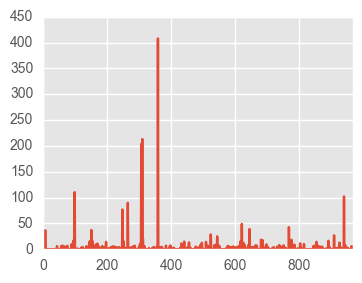

In [18]:
Sales_Revenues['Revenue_CC'].plot()

##### There is an outlier for revenue

###### Slicing and Indexing Sales_revenue dataset based on three products and two type of machine learning problems

##### Classification

In [19]:
sales_MF = Sales_Revenues[['Client','Sale_MF']]


In [20]:
sales_CC = Sales_Revenues[['Client','Sale_CC']]


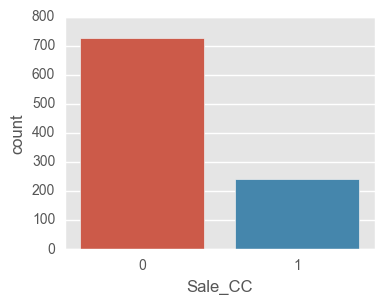

In [21]:
# Show value counts for a single categorical variable:
ax = sns.countplot(x="Sale_CC", data=sales_CC)

In [22]:
sales_CL = Sales_Revenues[['Client','Sale_CL']]

##### Regression

In [23]:
revenues_MF = Sales_Revenues[['Client','Revenue_MF']]
revenues_MF.shape

(969, 2)

In [24]:
revenues_MF['zscore'] = (revenues_MF.Revenue_MF - revenues_MF.Revenue_MF.mean())/revenues_MF.Revenue_MF.std(ddof=0)

In [25]:
revenues_CC = Sales_Revenues[['Client','Revenue_CC']]

In [26]:
revenues_CL = Sales_Revenues[['Client','Revenue_CL']]

###### Checking the ids of clients in Soc_dem and Inflow
Due to time constraint , it will be important to analyze a big dataset and do feature selection.

In [27]:
Soc_dem_Train = Soc_dem[Soc_dem['Client'].isin(Sales_Revenues['Client'])]
Soc_dem_Test = Soc_dem[~Soc_dem['Client'].isin(Sales_Revenues['Client'])]


In [28]:
Soc_dem_Train.shape

(969, 4)

In [29]:
Soc_dem_Test.shape

(646, 4)

In [30]:
#Separating Inflow_Outflow

inflow_Train = Inflow_Outflow[Inflow_Outflow['Client'].isin(Sales_Revenues['Client'])]
inflow_Test = Inflow_Outflow[~Inflow_Outflow['Client'].isin(Sales_Revenues['Client'])]

In [31]:
inflow_Train.shape

(951, 15)

In [32]:
inflow_Test.shape

(636, 15)

###### Hence, there are 18 client's id missing from training set, and 10 from test set.
Also, LEFT JOIN makes more sense as it returns all records on the left hand side table whether it has not match on the other table
###### Joining DataFrames

In [33]:
#Joining Soc_dem and Products_actBalance
soc_dem_product = pd.merge(left=Soc_dem,right=Products_ActBalance, how='left', left_on='Client', right_on='Client')



In [34]:
#Joining Soc_dem and Inflow_outflow
df1 = pd.merge(left=soc_dem_product,right=Inflow_Outflow, how='left', left_on='Client', right_on='Client')


###### Some of the values from inflow_outflow will be missing in the dataset . we will fill them with 0

In [35]:
#df1 = df1.fillna(0)

###### Replace male with 1 and female with 2

In [36]:
df1 = df1.replace({"Sex" : {"M" : 1, "F" : 2}})

###### Separate into training and test datasets

In [37]:
train = df1[df1['Client'].isin(Sales_Revenues['Client'])]
test = df1[~df1['Client'].isin(Sales_Revenues['Client'])]


In [38]:
train.shape

(969, 30)

In [39]:
test.shape

(646, 30)

###### Join Train and Sales_revenue to do some exploration

In [40]:
df = pd.merge(left=train,right=Sales_Revenues, how='left', left_on='Client', right_on='Client')

In [41]:
df = df.set_index('Client')

In [42]:
df.head(3)

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1217,1,38,165,1,1.0,NaN,NaN,NaN,NaN,110.768571,...,1.0,0.0,0.0,1.0,0,0,0,0.000000,0.000000,0.0
850,2,49,44,1,NaN,1.0,NaN,NaN,NaN,482.654643,...,6.0,0.0,0.0,1.0,0,1,0,0.000000,0.893929,0.0
1473,1,54,34,1,1.0,NaN,NaN,1.0,NaN,1599.840714,...,38.0,1.0,26.0,11.0,1,0,0,4.929643,0.000000,0.0


##### Continous Variables
* Age
* Tenure
* ActBal_CA
* ActBal_SA
* ActBal_MF
* ActBal_OVD
* ActBal_CC
* ActBal_CL
* VolumeCred
* VolumeCred_CA
* VolumeDeb_CA
* VolumeDebCash_Card
* VolumeDebCashless_Card
* VolumeDeb_PaymentOrder
* Revenue_MF
* Revenue_CC
* Revenue_CL

###### Categorical Variables
* Sex
* Count_CA
* Count_SA
* Count_MF
* Count_OVD
* Count_CC
* Count_CL
* TransactionsCred
* TransactionsCred_CA
* TransactionsDeb
* TransactionsDeb_CA
* TransactionsDebCash_Card
* TransactionsDebCashless_Card
* TransactionsDeb_PaymentOrder

##### Visualizing

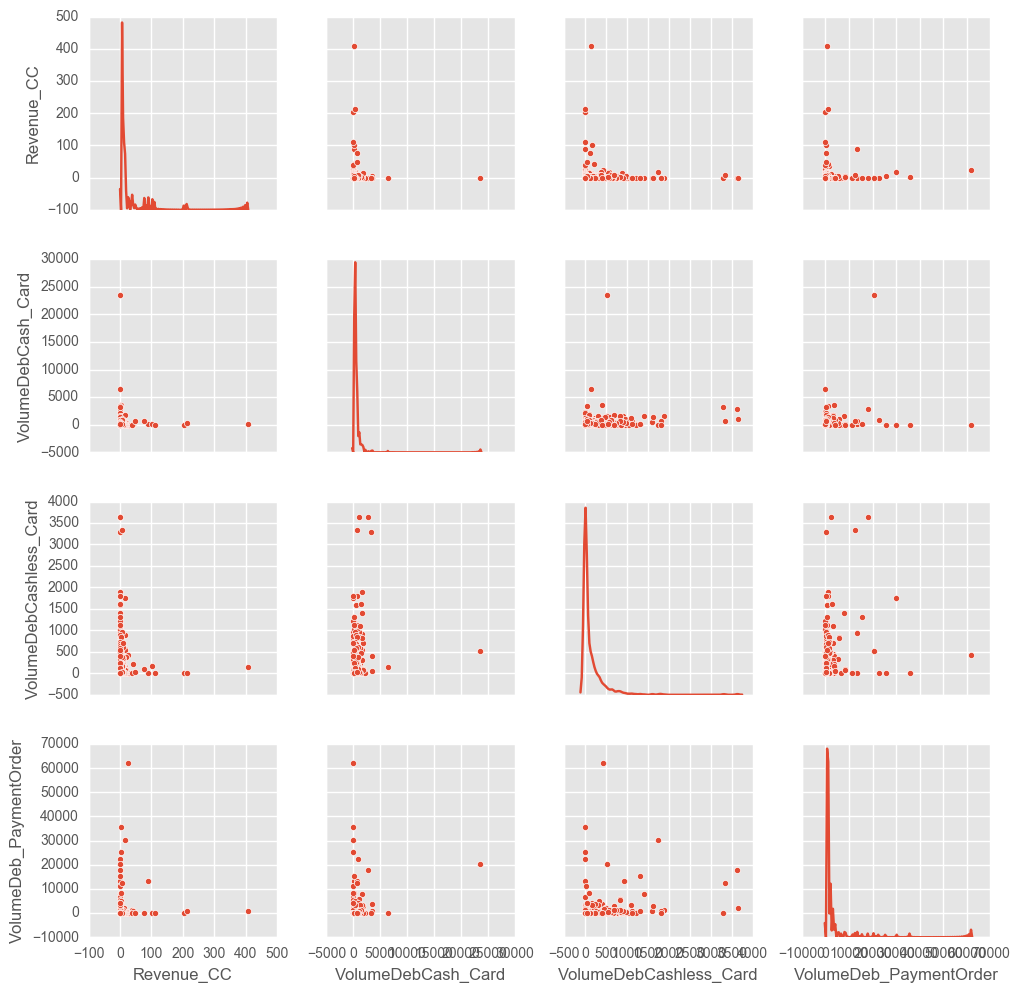

In [43]:
#Pair Plot
plt.figure()
sns.pairplot(data=df[['Revenue_CC','VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder']], diag_kind='kde' )

###### We will remove the outlier in Revenue_CL

In [44]:
df['Revenue_CL'].max()

133.27535714285713

In [45]:
df.loc[df['Revenue_CL'] == 133.27535714285713]

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1549,1,34,237,1,NaN,NaN,NaN,NaN,NaN,2181.302143,...,9.0,0.0,1.0,6.0,1,1,1,0.368214,2.679286,133.275357


In [46]:
df = df.loc[df['Revenue_CL'] != 133.27535714285713]

In [47]:
df['Revenue_CL'].mean()

3.4702623229043668

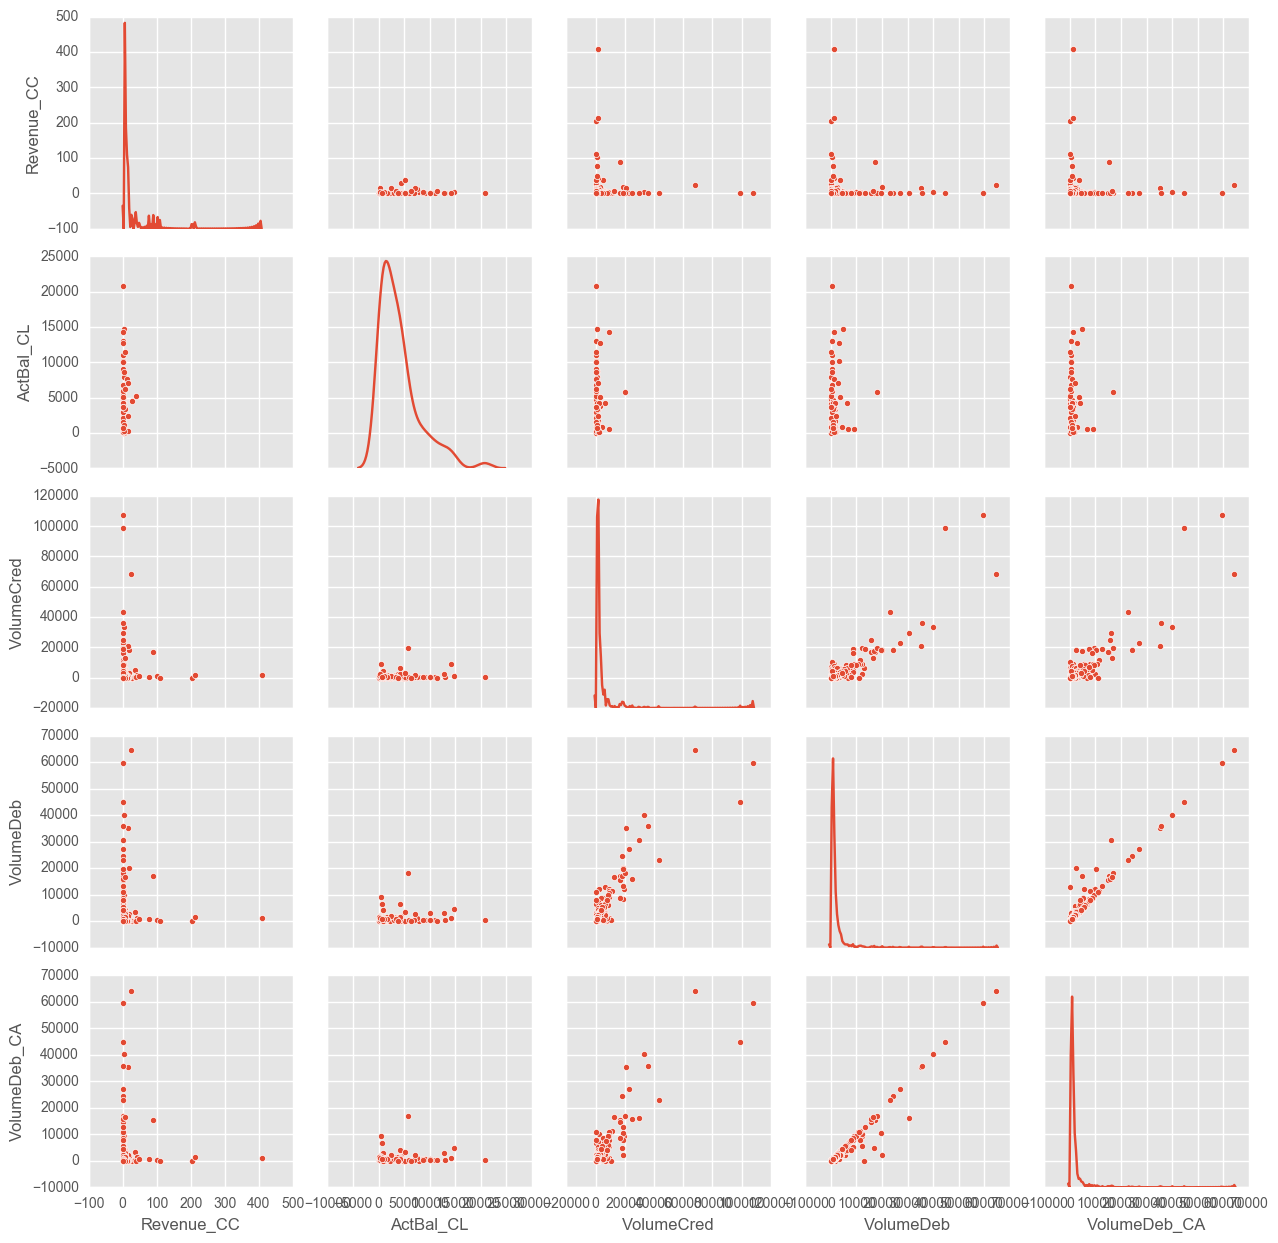

In [48]:
#Pair Plot
#Kde are more robust than histogram to handle nan
plt.figure()
sns.pairplot(data=df[['Revenue_CC','ActBal_CL', 'VolumeCred', 'VolumeDeb', 'VolumeDeb_CA']], diag_kind='kde')

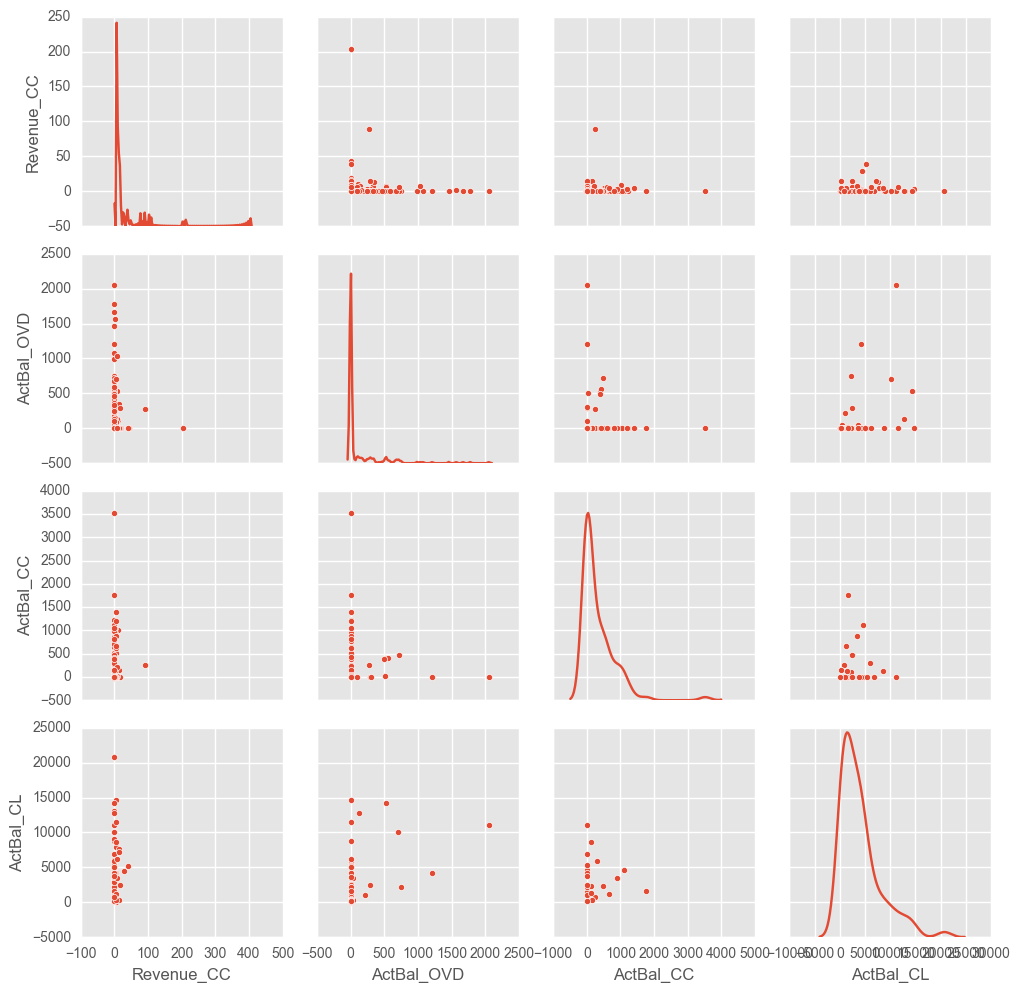

In [49]:
#Pair Plot
plt.figure()
sns.pairplot(data=df[['Revenue_CC','ActBal_OVD', 'ActBal_CC', 'ActBal_CL']], diag_kind='kde')

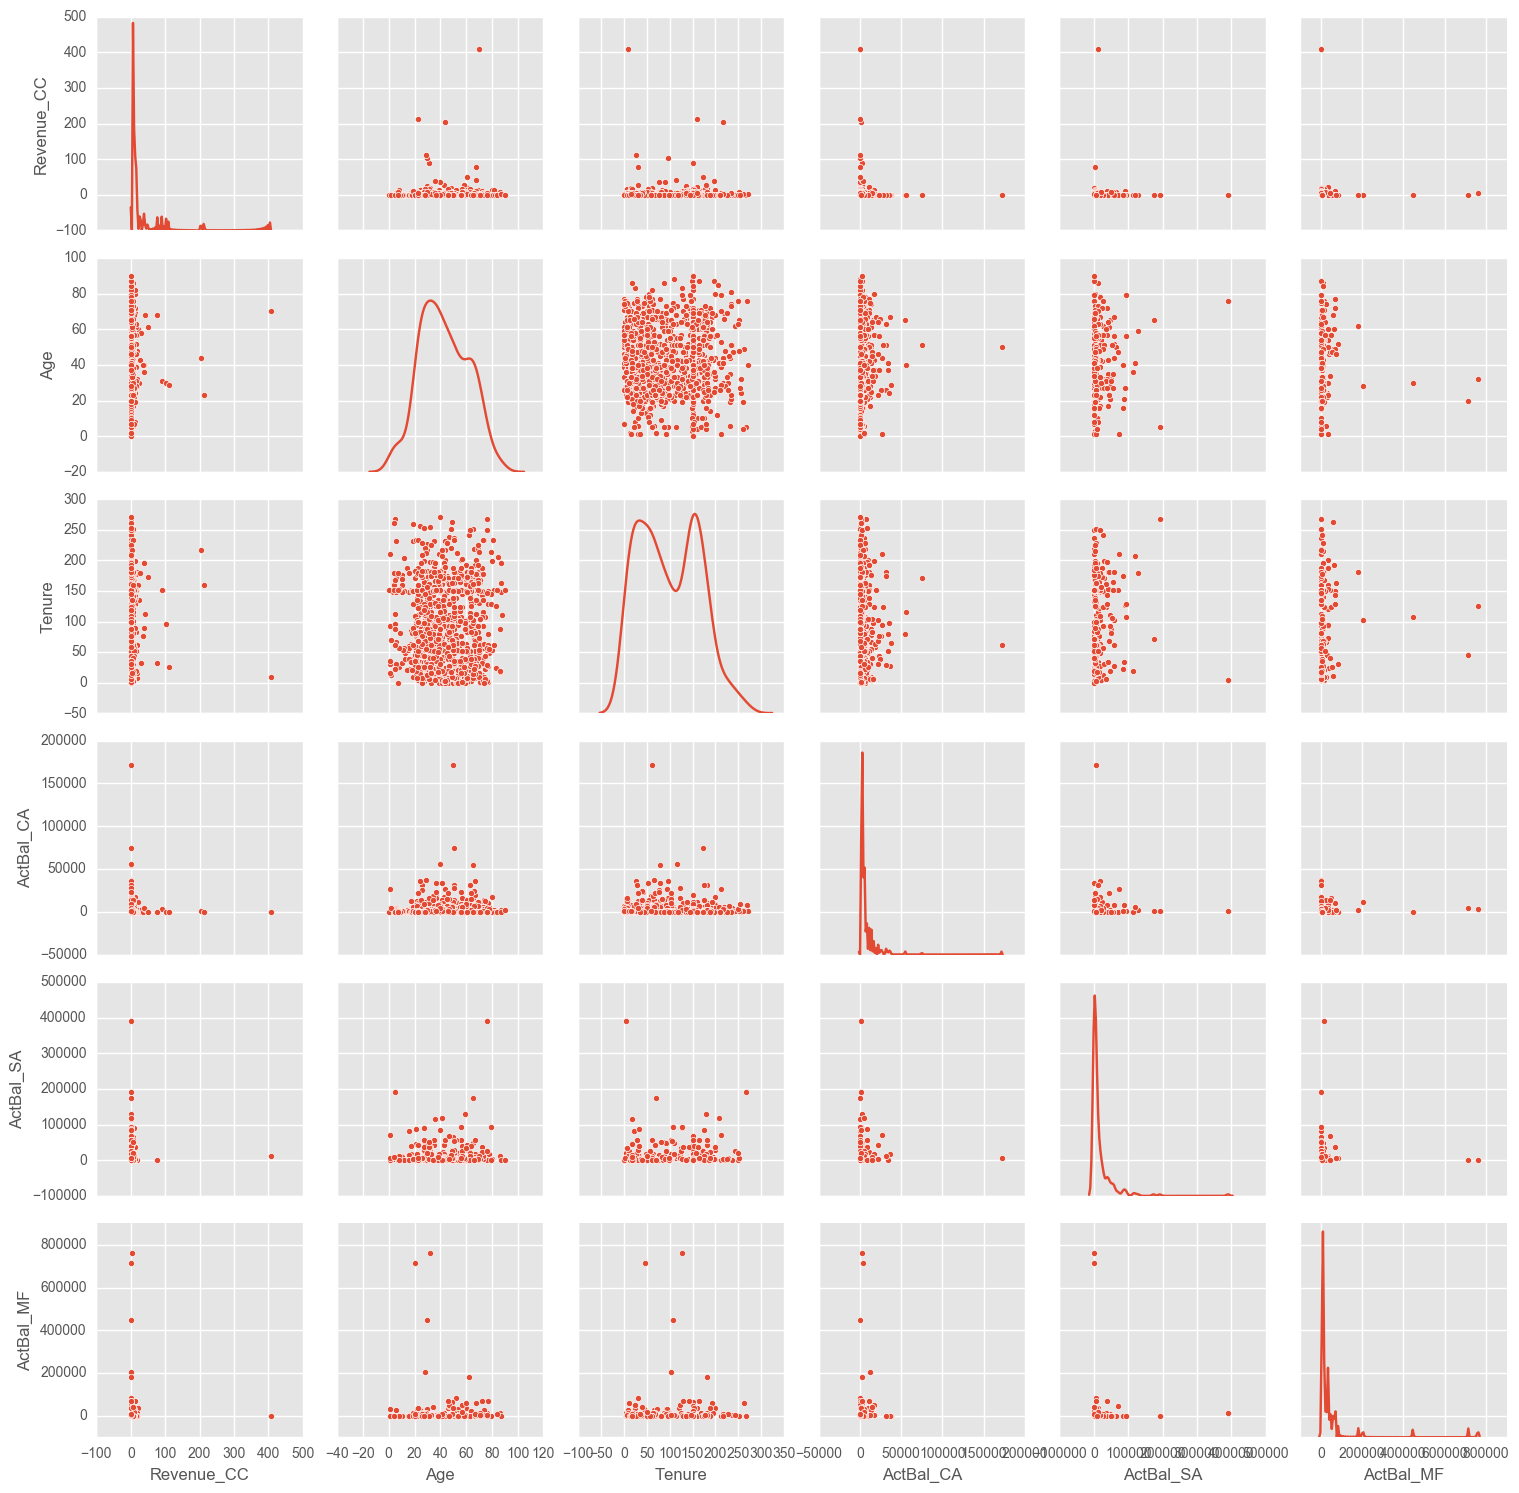

In [50]:
#Pair Plot
plt.figure()
sns.pairplot(data=df[['Revenue_CC','Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF']], diag_kind='kde')

### There are few outliers in the dataset. E.g in age vs Revenue_cl is one. Normally , we should explore more about these anamolies.

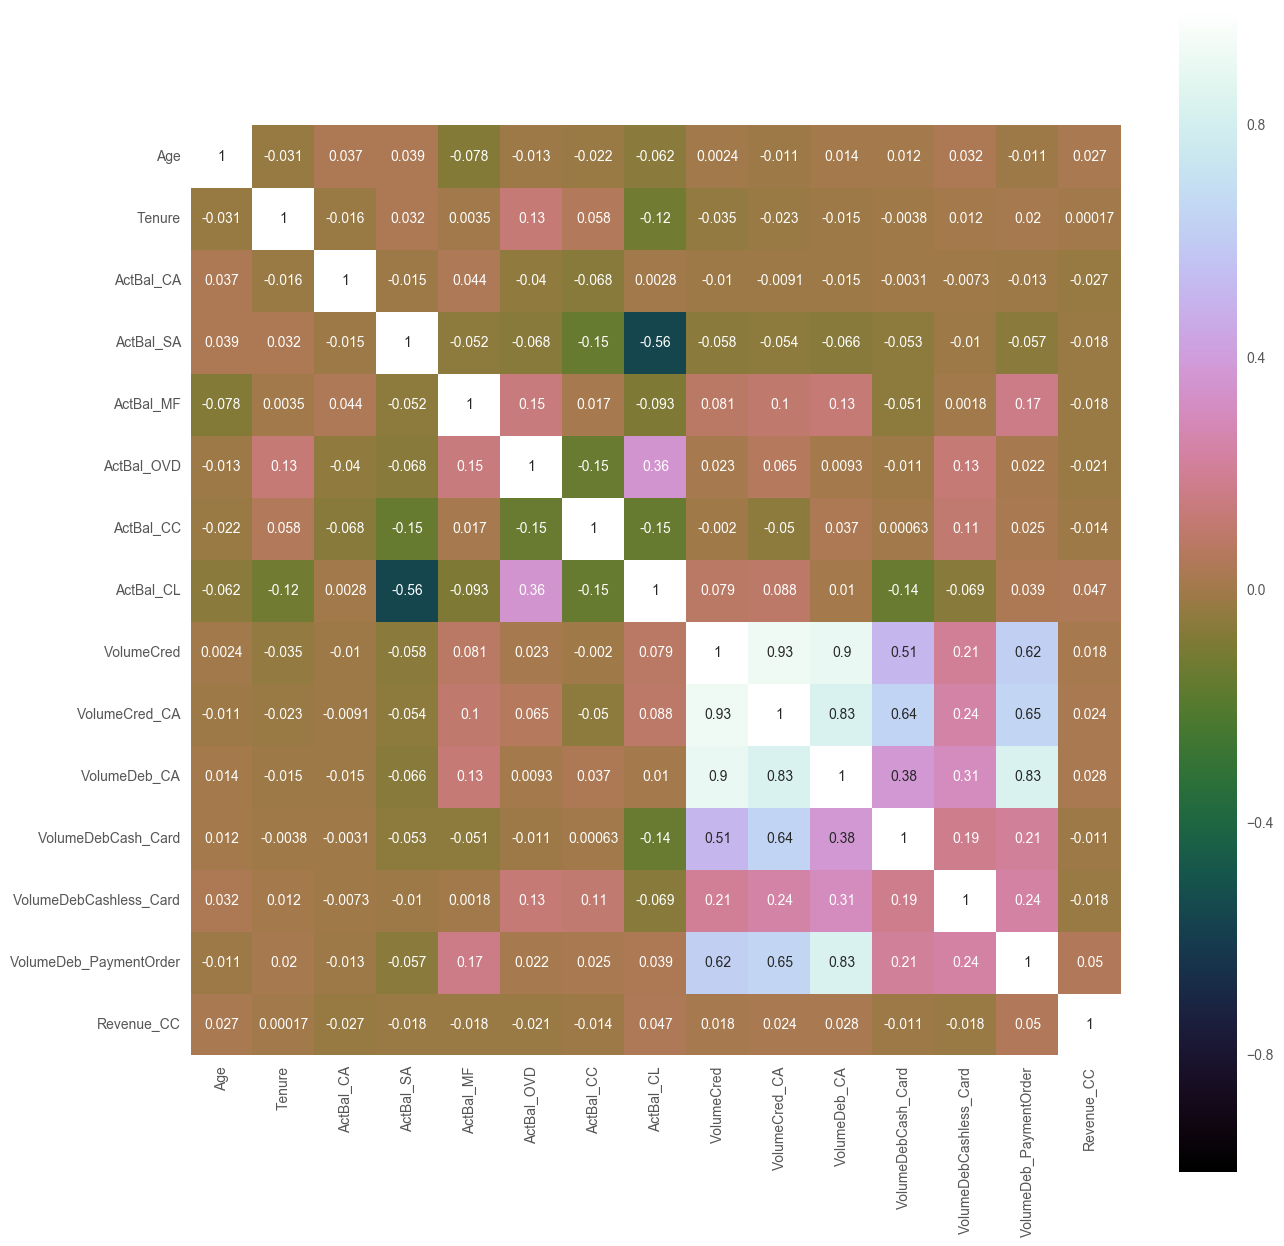

In [51]:
corr = df[['Age','Tenure','ActBal_CA','ActBal_SA','ActBal_MF','ActBal_OVD','ActBal_CC','ActBal_CL','VolumeCred','VolumeCred_CA',
'VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','Revenue_CC']].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, vmax=1, square=True,annot=True,cmap='cubehelix')

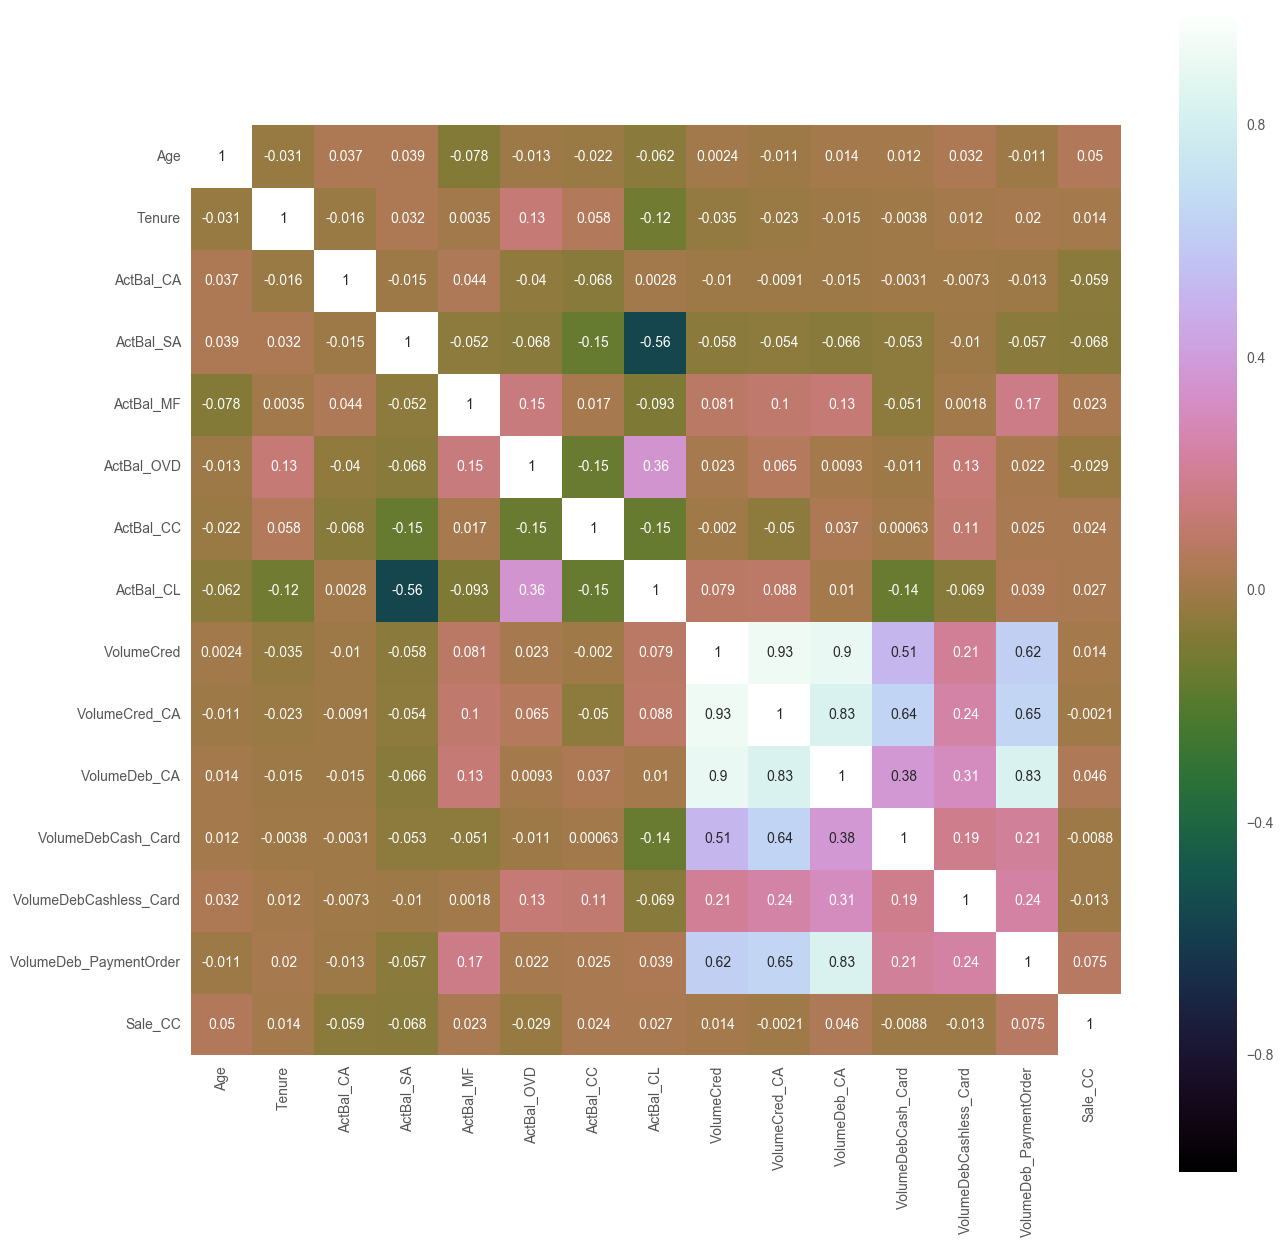

In [52]:
corr = df[['Age','Tenure','ActBal_CA','ActBal_SA','ActBal_MF','ActBal_OVD','ActBal_CC','ActBal_CL','VolumeCred','VolumeCred_CA',
'VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','Sale_CC']].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, vmax=1, square=True,annot=True,cmap='cubehelix')

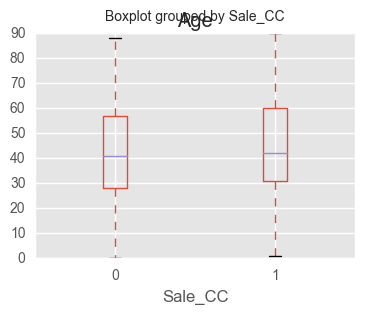

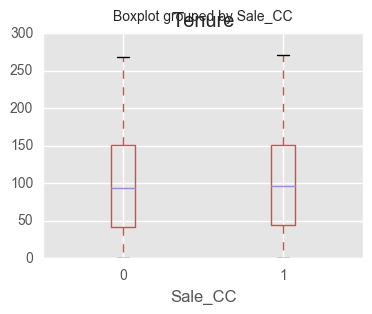

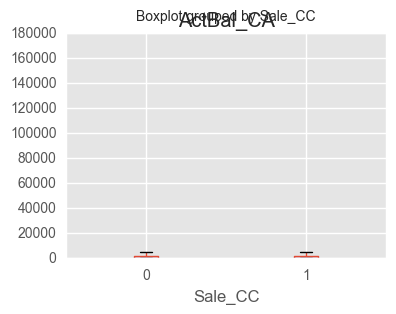

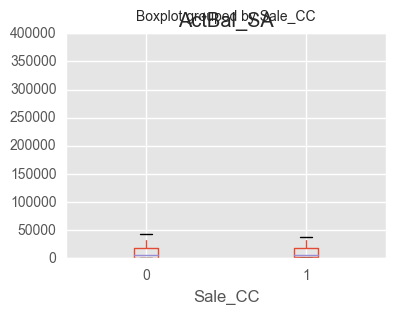

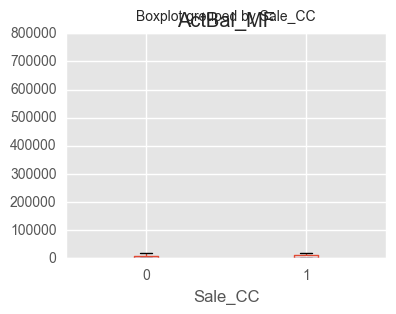

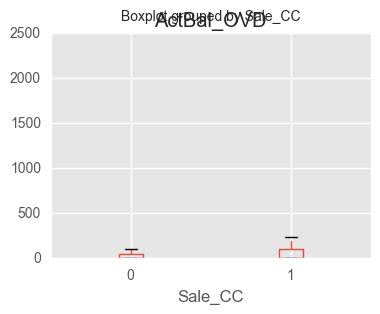

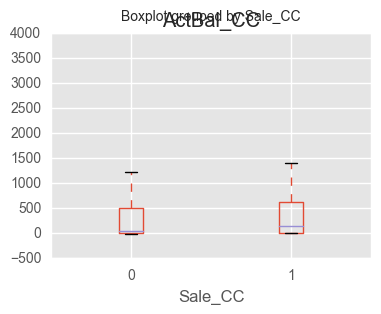

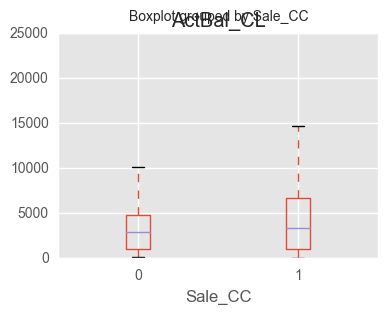

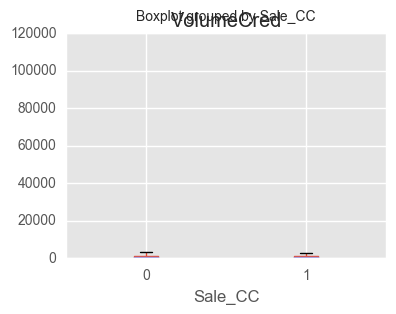

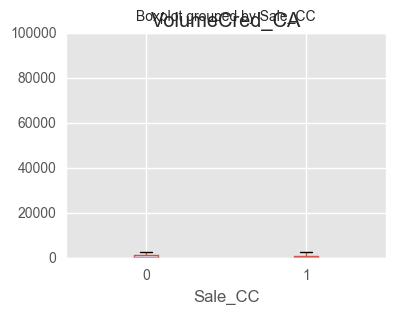

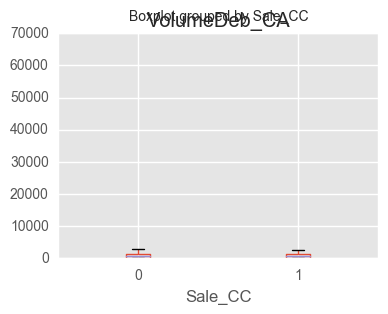

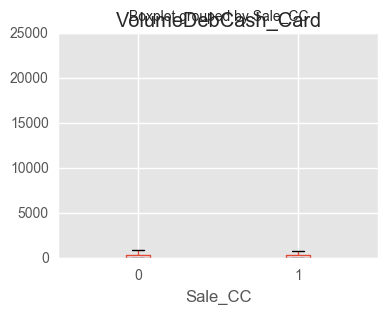

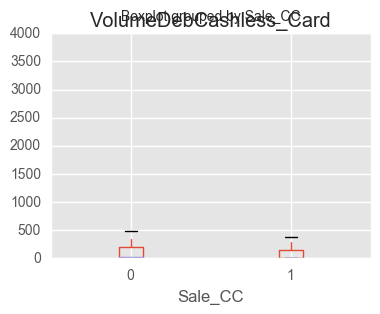

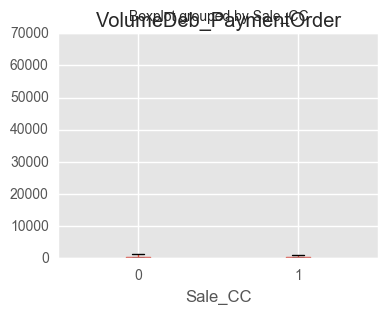

In [53]:
continous_list = ['Age','Tenure','ActBal_CA','ActBal_SA','ActBal_MF','ActBal_OVD','ActBal_CC','ActBal_CL','VolumeCred','VolumeCred_CA',
'VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder']

for list in continous_list:
    df.boxplot(column= list, by = 'Sale_CC')

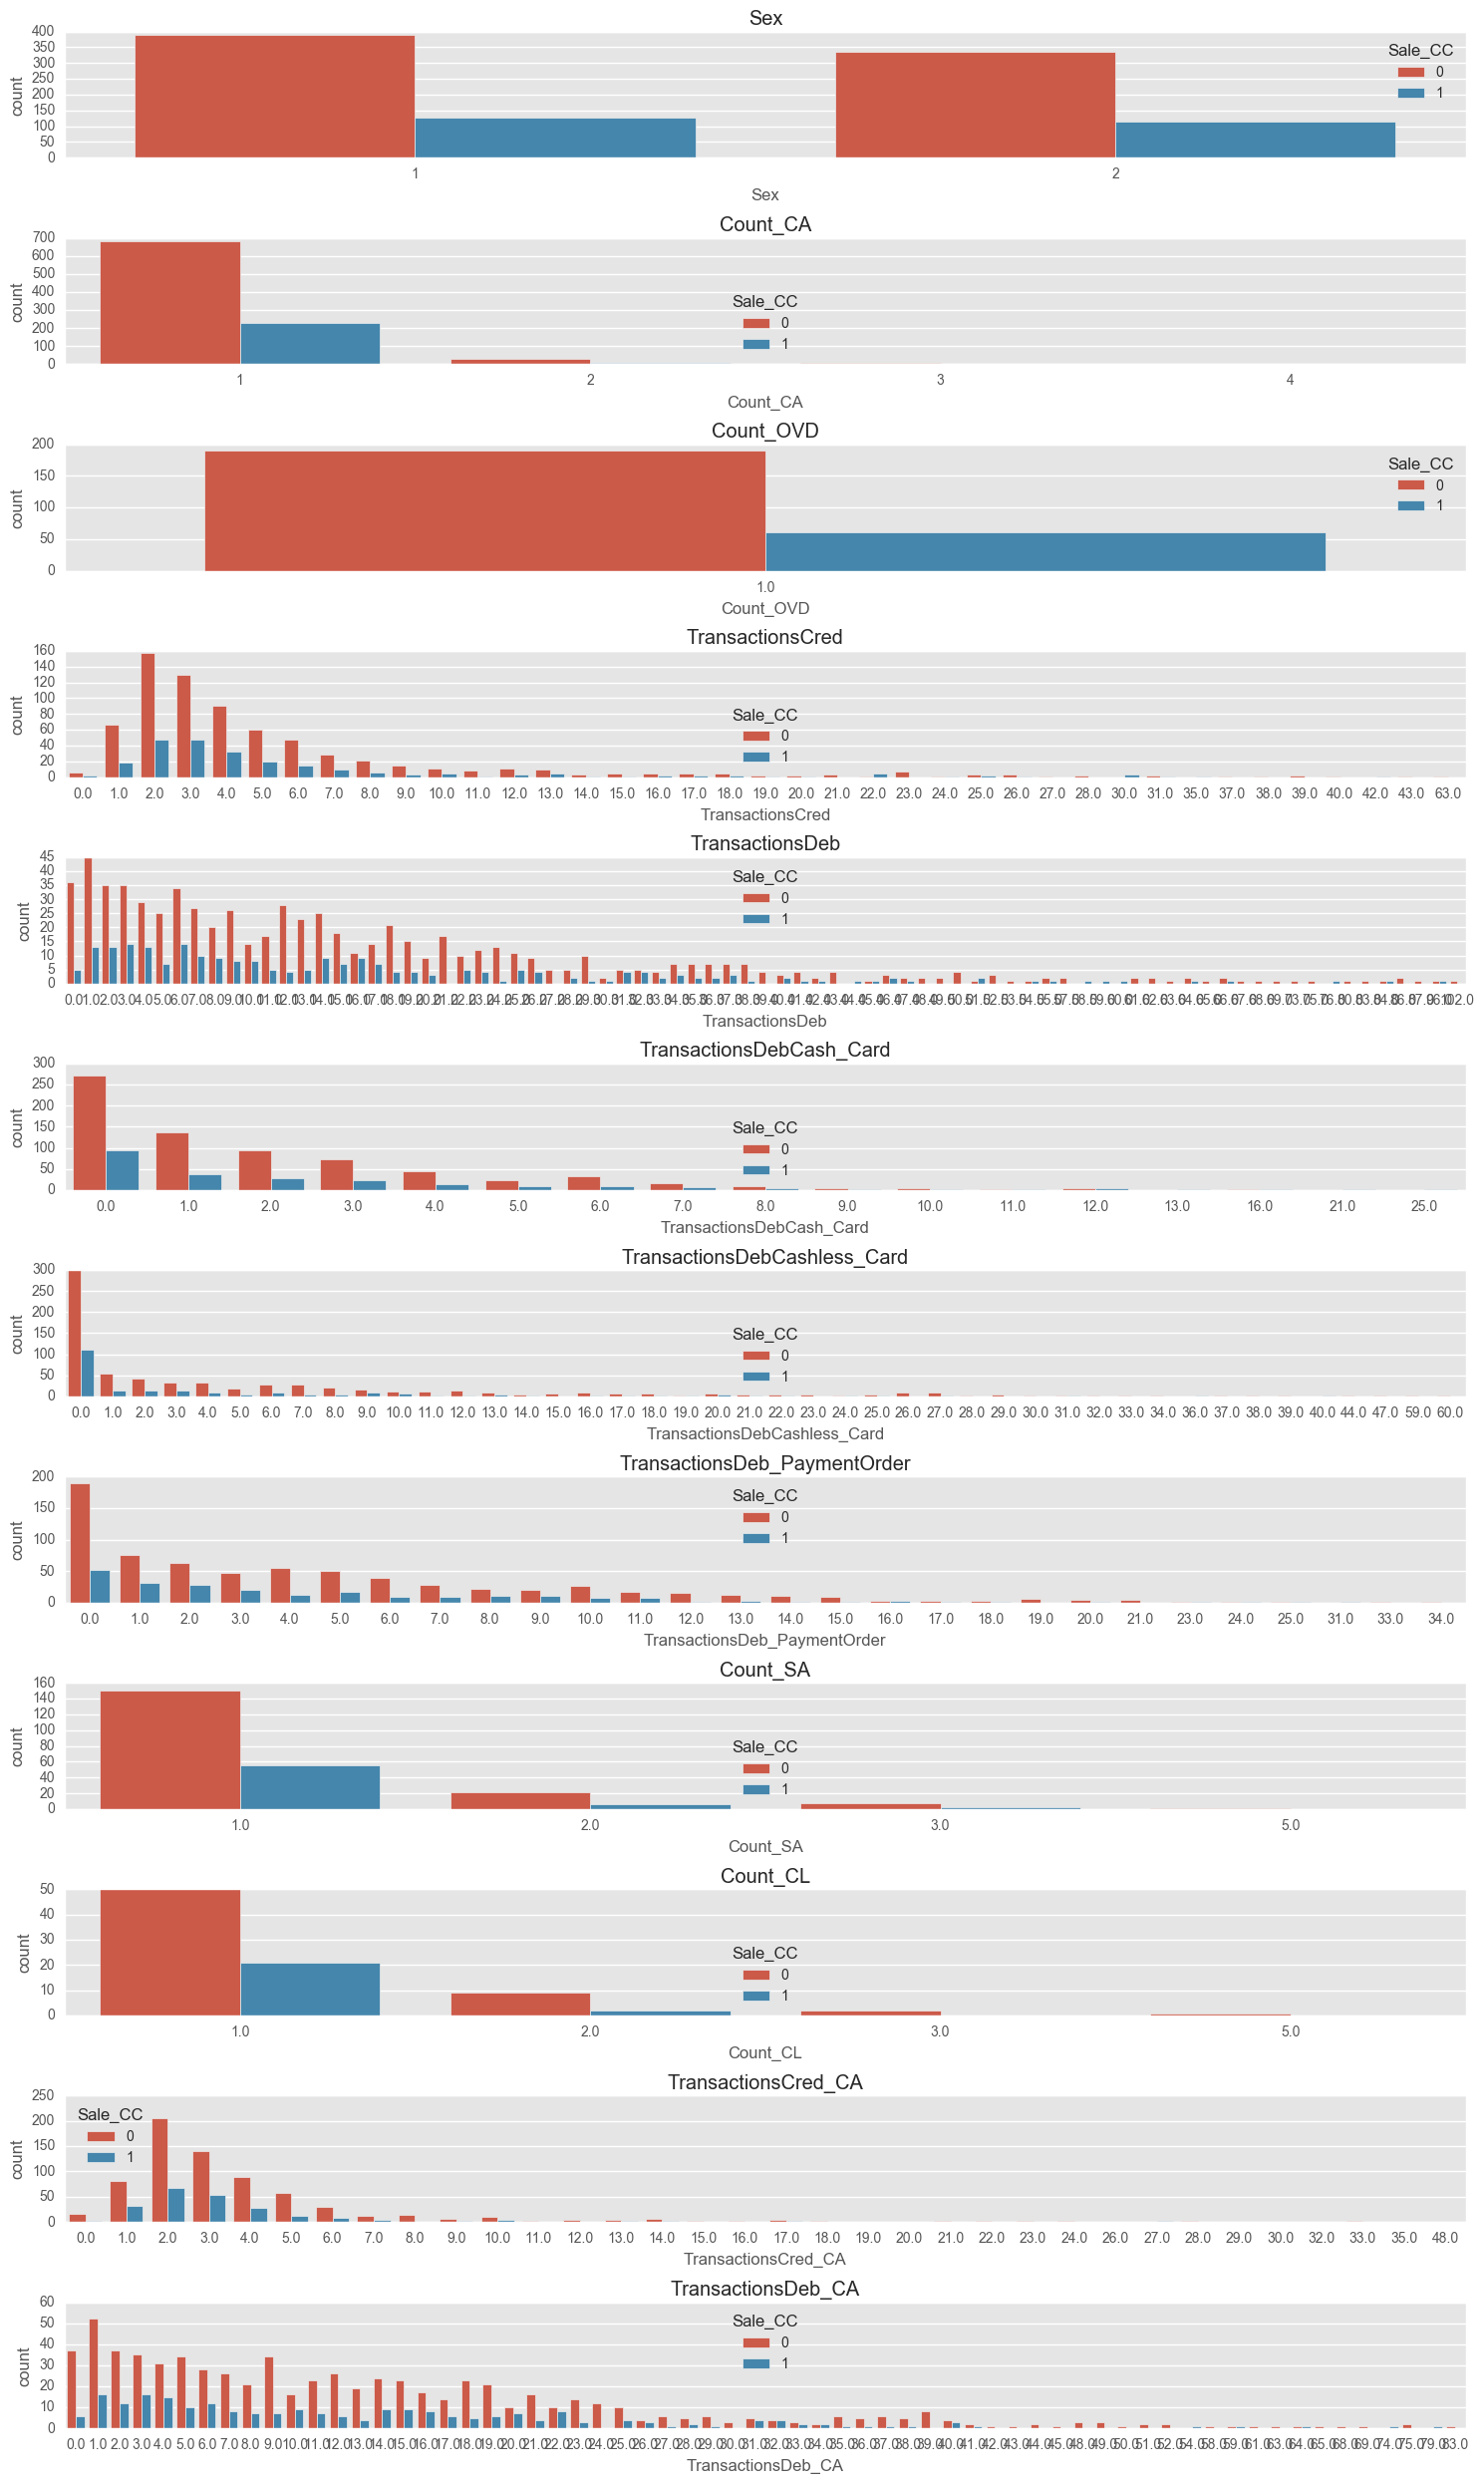

In [54]:
f, axarr = plt.subplots(12, figsize=(15, 25))

sns.countplot(x="Sex", hue="Sale_CC", data=df, ax=axarr[0])
sns.countplot(x="Count_CA", hue="Sale_CC", data=df, ax=axarr[1])
sns.countplot(x="Count_OVD", hue="Sale_CC", data=df, ax=axarr[2])
sns.countplot(x="TransactionsCred", hue="Sale_CC", data=df, ax=axarr[3])
sns.countplot(x="TransactionsDeb", hue="Sale_CC", data=df, ax=axarr[4])
sns.countplot(x="TransactionsDebCash_Card", hue="Sale_CC", data=df, ax=axarr[5])
sns.countplot(x="TransactionsDebCashless_Card", hue="Sale_CC", data=df, ax=axarr[6])
sns.countplot(x="TransactionsDeb_PaymentOrder", hue="Sale_CC", data=df, ax=axarr[7])
sns.countplot(x="Count_SA", hue="Sale_CC", data=df, ax=axarr[8])
sns.countplot(x="Count_CL", hue="Sale_CC", data=df, ax=axarr[9])
sns.countplot(x="TransactionsCred_CA", hue="Sale_CC", data=df, ax=axarr[10])
sns.countplot(x="TransactionsDeb_CA", hue="Sale_CC", data=df, ax=axarr[11])


axarr[0].set_title('Sex')
axarr[1].set_title('Count_CA')
axarr[2].set_title('Count_OVD')
axarr[3].set_title('TransactionsCred')
axarr[4].set_title('TransactionsDeb')
axarr[5].set_title('TransactionsDebCash_Card')
axarr[6].set_title('TransactionsDebCashless_Card')
axarr[7].set_title('TransactionsDeb_PaymentOrder')
axarr[8].set_title('Count_SA')
axarr[9].set_title('Count_CL')
axarr[10].set_title('TransactionsCred_CA')
axarr[11].set_title('TransactionsDeb_CA')

plt.tight_layout()
plt.show()


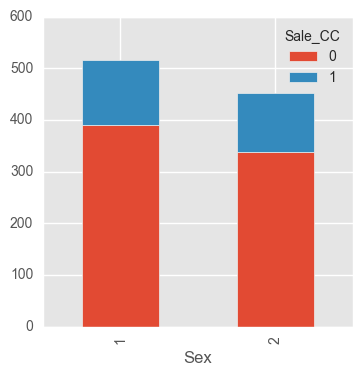

In [55]:
sex_sale_CL_table = pd.crosstab(index=df["Sex"], 
                          columns=df["Sale_CC"])
sex_sale_CL_table.plot(kind="bar", 
                 figsize=(4,4),
                 stacked=True)


###### So even if we send more marketing to males, females are equally likely to have a sale as males.

In [56]:
train_cl = train.copy() # create a copy of data frame
train_cl = train_cl.set_index("Client")

###### Target variable

In [57]:
y_CC = Sales_Revenues['Sale_CC']

###### Define Median Absolute Deviation Function

In [58]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

###### Handle Missing Data for continuous data
1. If any column contains more than 50 entries of missing data, drop the column
2. If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column (the median imputation used on missing values is very crude. 
3. Remove outliers using Median Absolute Deviation
4. Calculate skewness for each variable and if greater than 0.75 transform it
5. Apply the sklearn.Normalizer to each column

In [59]:
continous = ['Age','Tenure','ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL','VolumeCred','VolumeCred_CA','VolumeDeb',
             'VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder']
for col in continous:
    if np.sum(train_cl[col].isnull()) > 900:
        #print("Removing Column: {}".format(col))
        train_cl = train_cl.drop(col, axis = 1)
    elif np.sum(train_cl[col].isnull()) > 0:
        #print("Replacing with Median: {}".format(col))
        median = train_cl[col].median()
        idx = np.where(train_cl[col].isnull())[0]
        train_cl[col].iloc[idx] = median
        
        
        outliers = np.where(is_outlier(train_cl[col]))
        train_cl[col].iloc[outliers] = median
        
               
        if skew(train_cl[col]) > 0.75:
            #print("Skewness Detected: {}".format(col))
            train_cl[col] = np.log(train_cl[col])
            train_cl[col] = train_cl[col].apply(lambda x: 0 if x == -np.inf else x)
        
        train_cl[col] = Normalizer().fit_transform(train_cl[col].reshape(1,-1))[0]

###### Handle Missing Data for Categorical Data
1. If any column contains more than 50 entries of missing data, drop the column
1. If any column contains fewer that 50 entries of missing data, replace those values with the 0

In [60]:
categorical = ['Sex','Count_CA','Count_SA','Count_MF','Count_OVD','Count_CC','Count_CL','TransactionsCred','TransactionsCred_CA',
               'TransactionsDeb','TransactionsDeb_CA','TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
for col in categorical:
    if np.sum(train_cl[col].isnull()) > 50:
        train_cl = train_cl.drop(col, axis = 1)
        continue
    elif np.sum(train_cl[col].isnull()) > 0:
        train_cl[col] = train_cl[col].fillna(0)

##### Feature Selection

##### Using Variance Threshold

In [61]:
#Find all features with more than 90% variance in values.
threshold = 0.90
vt = VarianceThreshold().fit(train_cl)

# Find feature names
feat_var_threshold = train_cl.columns[vt.variances_ > threshold * (1-threshold)]
#top 5 feature names
feat_var_threshold[0:5]

Index(['Sex', 'Age', 'Tenure', 'Count_CA', 'ActBal_CA'], dtype='object')

###### Features according to Random Forest Classifier

In [62]:
model = RandomForestClassifier()
model.fit(train_cl, y_CC)

feature_imp = pd.DataFrame(model.feature_importances_, index=train_cl.columns, columns=["importance"])
feat_imp_5 = feature_imp.sort_values("importance", ascending=False).head(5).index
feat_imp_5

Index(['ActBal_CA', 'VolumeCred_CA', 'Tenure', 'Age', 'VolumeDeb_CA'], dtype='object')

###### As some of the features are negative, We will skip Univariate feature selection using chi2chi2 test.

###### Recursive Feature Elimination
Select 5 features from using recursive feature elimination (RFE) with logistic regression model.

In [63]:
rfe = RFE(LogisticRegression(), 5)
rfe.fit(train_cl, y_CC)

feature_rfe_scoring = pd.DataFrame({
        'feature': train_cl.columns,
        'score': rfe.ranking_
    })

feat_rfe_5 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_5

array(['Sex', 'VolumeCred', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder'], dtype=object)

###### Final feature selection
Finally features selected by all methods will be merged together

In [64]:
features = np.hstack([
        feat_var_threshold[0:5], 
        feat_imp_5,
        feat_rfe_5
    ])

features = np.unique(features)
print('Final features set for Customer Loans :\n')
for f in features:
    print("\t-{}".format(f))

Final features set for Customer Loans :

	-ActBal_CA
	-Age
	-Count_CA
	-Sex
	-Tenure
	-VolumeCred
	-VolumeCred_CA
	-VolumeDebCash_Card
	-VolumeDebCashless_Card
	-VolumeDeb_CA
	-VolumeDeb_PaymentOrder


##### Calculating the revenue

In [65]:
df2 = df.query('(61 < ActBal_CA < 3000)  & (18 < Age < 55)  & (Count_CA < 3)  & (250 < VolumeCred < 1400) & ( 200 < VolumeCred_CA < 1304) & (20 < VolumeDebCash_Card < 350) & (20 < VolumeDebCashless_Card < 180) ')

In [66]:
df2['Revenue_CC'].mean()


0.9349872448979591

###### Based on the different features where people are able to buy a product

In [67]:
call_to_list = test.query('(61 < ActBal_CA < 3000)  & (18 < Age < 55)  & (Count_CA < 3)  & (250 < VolumeCred < 1400) & ( 200 < VolumeCred_CA < 1304) & (20 < VolumeDebCash_Card < 350) & (20 < VolumeDebCashless_Card < 180) ')

In [68]:
call_to_list

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
9,528,2,19,70,1,1.0,NaN,NaN,NaN,NaN,...,390.056429,390.056429,125.000000,70.842143,190.821429,10.0,10.0,4.0,3.0,2.0
117,1578,1,30,131,1,1.0,2.0,NaN,NaN,NaN,...,586.905714,586.905714,89.285714,160.512857,333.714286,22.0,22.0,2.0,12.0,7.0
147,1611,2,41,181,1,NaN,3.0,NaN,NaN,NaN,...,1104.685714,1104.685714,178.571429,32.142857,890.578571,11.0,11.0,1.0,3.0,6.0
220,1028,2,29,39,1,NaN,NaN,NaN,1.0,NaN,...,379.685714,379.685714,285.714286,60.257143,31.750000,6.0,6.0,1.0,3.0,1.0
298,471,2,29,38,1,NaN,8.0,NaN,NaN,NaN,...,315.770714,315.770714,239.285714,76.485000,0.000000,14.0,14.0,7.0,7.0,0.0
348,652,1,50,112,2,2.0,NaN,NaN,NaN,NaN,...,303.010000,303.010000,177.810000,64.271429,60.714286,12.0,12.0,2.0,6.0,3.0
446,677,1,25,179,1,NaN,NaN,NaN,NaN,NaN,...,216.296429,216.296429,103.571429,112.725000,0.000000,13.0,13.0,4.0,9.0,0.0
462,1395,2,41,64,1,NaN,NaN,1.0,NaN,NaN,...,420.164286,420.164286,307.142857,107.092857,0.000000,19.0,19.0,6.0,8.0,0.0
547,919,2,29,5,1,NaN,NaN,NaN,NaN,NaN,...,927.638571,898.889286,278.571429,157.672143,438.728214,26.0,22.0,4.0,7.0,8.0
557,1064,1,39,98,1,NaN,NaN,NaN,NaN,NaN,...,1216.635000,1120.420714,53.571429,106.107143,820.928571,20.0,14.0,2.0,6.0,7.0


In [69]:
submission_CC = pd.DataFrame()
submission_CC["Client"] = call_to_list.Client


submission_CC.to_csv("sub_CC.csv",index=False)

###### Prepare dataset using the features for Sale_CL

In [70]:
#copy the test dataset
test_cl = test.copy

In [71]:
X = train_cl.ix[:, features]
test_CL = test.ix[:,features]
print('Train features shape: {}'.format(X.shape))
print('Test_MF features shape: {}'.format(test_CL.shape))
print('Target label shape: {}'. format(y_CC.shape))

Train features shape: (969, 11)
Test_MF features shape: (646, 11)
Target label shape: (969,)


###### Evaluate Algorithms



In [72]:
seed = 7
processors=1
num_folds=3
num_instances=len(X)
scoring='accuracy'

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)

In [73]:
# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(probability=True)))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, y_CC, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (0.751) +/- (0.023)
LDA: (0.751) +/- (0.023)
K-NN: (0.687) +/- (0.026)
CART: (0.600) +/- (0.017)
NB: (0.741) +/- (0.033)
SVC: (0.748) +/- (0.021)


In [74]:
cart = DecisionTreeClassifier()
num_trees = 100

model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

results = cross_val_score(model, X, y_CC, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.727) +/- (0.034)


In [75]:
num_trees = 100
num_features = 8

model = RandomForestClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, y_CC, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.723) +/- (0.029)


In [76]:
model = GradientBoostingClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, y_CC, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.718) +/- (0.026)


###### Multi-Layer Perceptron Classifier model

In [77]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(30,30,30))
results = cross_val_score(model, X, y_CC, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.632) +/- (0.096)


###### Hypermeter Tuning

In [78]:
#Random Forest
rf_grid = GridSearchCV(
    estimator = RandomForestClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_features': [2, 8],
        'max_depth': [8, 10],
        'bootstrap': [True]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X, y_CC)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.7523219814241486
{'max_depth': 8, 'n_estimators': 200, 'criterion': 'entropy', 'max_features': 2, 'bootstrap': True}


In [79]:
#logistic Regression
lr_grid = GridSearchCV(
    estimator = LogisticRegression(random_state=seed),
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 1, 10, 100, 1000]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lr_grid.fit(X, y_CC)

print(lr_grid.best_score_)
print(lr_grid.best_params_)

0.7512899896800825
{'C': 0.001, 'penalty': 'l1'}


In [80]:
#Linear Discriminant Analysis
lda_grid = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = {
        'solver': ['lsqr'],
        'shrinkage': [0, 0.25, 0.5, 0.75, 1],
        'n_components': [None, 2, 5, 10]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lda_grid.fit(X, y_CC)

print(lda_grid.best_score_)
print(lda_grid.best_params_)

0.7512899896800825
{'n_components': None, 'shrinkage': 0, 'solver': 'lsqr'}


In [81]:
#Voting Ensemble
# Create sub models
estimators = []

estimators.append(('lr', LogisticRegression(penalty='l1', C=.001)))
estimators.append(('lda', LinearDiscriminantAnalysis(shrinkage = 0.25, n_components= 'None', solver= 'lsqr')))
estimators.append(('svc', SVC(probability=True)))
estimators.append(('rf', RandomForestClassifier(bootstrap=True, max_depth=8, n_estimators=100, max_features=2, criterion='entropy', random_state=seed)))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft', weights=[3,1,3,1])

results = cross_val_score(ensemble, X, y_CC, cv=kfold, scoring=scoring,n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.751) +/- (0.024)


In this case we have 75% accuracy. The accuracy of a classifier is given by the number of correctly classified samples divided by the total number of samples classified. In other words, it means that it is the proportion of the total number of predictions that were correct.
Another tool to estimate the performance of a classifier is the confusion matrix. In this matrix each column represents the instances in a predicted class, while each row represents the instances in an actual class. Using the module metrics it is pretty easy to compute and print the matrix:

##### Confusion Matrix

In [82]:
from sklearn.model_selection import train_test_split
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y_CC, random_state=0)


In [83]:
ensemble.fit(X_train,y_train) # train
print (ensemble.score(X_test,y_test)) # test

0.761316872428


In [84]:
#Example of confusion matrix usage to evaluate the quality of the output of a classifier on the data set. 
from sklearn.metrics import confusion_matrix
print (confusion_matrix(ensemble.predict(X_test),y_test))


[[185  58]
 [  0   0]]


In [85]:
from sklearn.metrics import classification_report
print (classification_report(ensemble.predict(X_test), y_test, target_names=['Yes', 'No']))

             precision    recall  f1-score   support

        Yes       1.00      0.76      0.86       243
         No       0.00      0.00      0.00         0

avg / total       1.00      0.76      0.86       243

